/Users/xrz/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


[0]	train-logloss:0.69021	train-custom:0.00000	test-logloss:0.69019	test-custom:0.00000
[1]	train-logloss:0.68730	train-custom:0.00000	test-logloss:0.68725	test-custom:0.00000
[2]	train-logloss:0.68444	train-custom:0.00000	test-logloss:0.68436	test-custom:0.00000
[3]	train-logloss:0.68166	train-custom:0.00000	test-logloss:0.68157	test-custom:0.00000
[4]	train-logloss:0.67885	train-custom:0.00000	test-logloss:0.67875	test-custom:0.00000
[5]	train-logloss:0.67614	train-custom:0.00000	test-logloss:0.67610	test-custom:0.00000
[6]	train-logloss:0.67339	train-custom:0.00000	test-logloss:0.67330	test-custom:0.00000


/Users/xrz/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/Users/xrz/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py:39: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[7]	train-logloss:0.67078	train-custom:0.00000	test-logloss:0.67074	test-custom:0.00000
[8]	train-logloss:0.66812	train-custom:0.00000	test-logloss:0.66805	test-custom:0.00000
[9]	train-logloss:0.66558	train-custom:0.00000	test-logloss:0.66555	test-custom:0.00000
[10]	train-logloss:0.66302	train-custom:0.00000	test-logloss:0.66291	test-custom:0.00000
[11]	train-logloss:0.66055	train-custom:0.00000	test-logloss:0.66049	test-custom:0.00000
[12]	train-logloss:0.65807	train-custom:0.00000	test-logloss:0.65793	test-custom:0.00000
[13]	train-logloss:0.65567	train-custom:0.00000	test-logloss:0.65556	test-custom:0.00000
[14]	train-logloss:0.65325	train-custom:0.00000	test-logloss:0.65307	test-custom:0.00000
[15]	train-logloss:0.65092	train-custom:0.00000	test-logloss:0.65079	test-custom:0.00000
[16]	train-logloss:0.64858	train-custom:0.00000	test-logloss:0.64842	test-custom:0.00000
[17]	train-logloss:0.64626	train-custom:0.00000	test-logloss:0.64611	test-custom:0.00000
[18]	train-logloss:0.643

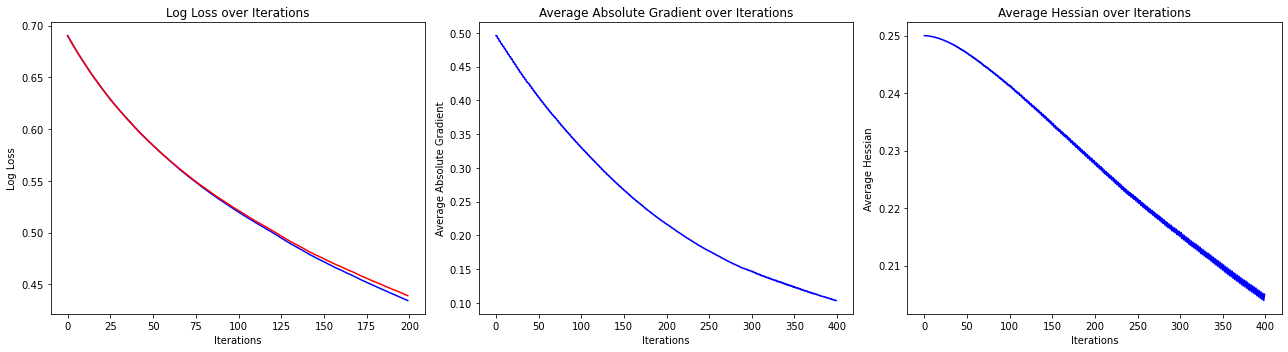

In [1]:
import xgboost as xgb
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# Generate a synthetic binary classification dataset
X, y = make_classification(n_samples=20000, n_features=20, n_informative=15, n_classes=2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Convert to DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Parameters for binary classification
params = {
    'max_depth': 3,  # Model complexity
    'eta': 0.01,  # Learning rate
    'lambda': 1,  # L2 regularization
    'alpha': 0.1,  # L1 regularization
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}

# Initialize lists to store the metrics
avg_gradients = []
avg_hessians = []
evals_result = {}  # Dictionary to store evaluation results

# Custom evaluation function to capture gradients and Hessians
def capture_gradients_hessians(preds, dtrain):
    labels = dtrain.get_label()
    preds = 1.0 / (1.0 + np.exp(-preds))
    gradients = preds - labels
    hessians = preds * (1 - preds)
    avg_gradients.append(np.abs(gradients).min())
    avg_hessians.append(hessians.mean())
    return 'custom', 0

# Training the model
num_boost_round = 200
bst = xgb.train(params, dtrain, num_boost_round, [(dtrain, 'train'), (dtest, 'test')],
                feval=capture_gradients_hessians, evals_result=evals_result)

# Visualizing the loss, gradients, and Hessians
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Plotting log loss
train_loss = evals_result['train']['logloss']
test_loss = evals_result['test']['logloss']
ax[0].plot(train_loss, color = 'blue',label='Train Loss')
ax[0].plot(test_loss,color = 'red', label='Test Loss')
ax[0].set_title('Log Loss over Iterations')
ax[0].set_xlabel('Iterations')
ax[0].set_ylabel('Log Loss')
#ax[0].legend()

# Plotting average absolute gradients
ax[1].plot(avg_gradients, color = 'blue' ,label='Average Absolute Gradient')
ax[1].set_title('Average Absolute Gradient over Iterations')
ax[1].set_xlabel('Iterations')
ax[1].set_ylabel('Average Absolute Gradient')
#ax[1].legend()

# Plotting average Hessians
ax[2].plot(avg_hessians, color = 'blue',label='Average Hessian')
ax[2].set_title('Average Hessian over Iterations')
ax[2].set_xlabel('Iterations')
ax[2].set_ylabel('Average Hessian')
#ax[2].legend()

plt.tight_layout()
plt.savefig('general.png',transparent = True)
plt.show()
